In [ ]:
import time
import numpy as np
np.bool = bool

from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
context = mx.cpu(); model_ctx=mx.cpu()
mx.random.seed(1719)

sorting the time series data by month-date-year format.

In [ ]:
def parser(x):
    return datetime.datetime.strptime(x,'%m/%d/%Y')

In [ ]:
import pandas as pd

In [ ]:
dataset_ex_df = pd.read_csv("AMZN.csv", header=0, parse_dates=[0], date_parser=parser)

In [ ]:
dataset_ex_df[['Date', 'Close']].head(3)

,Date,Close
0,2010-01-04,133.899994
1,2010-01-05,134.690002
2,2010-01-06,132.250000


In [ ]:
dataset_ex_df.shape

(2265, 20)

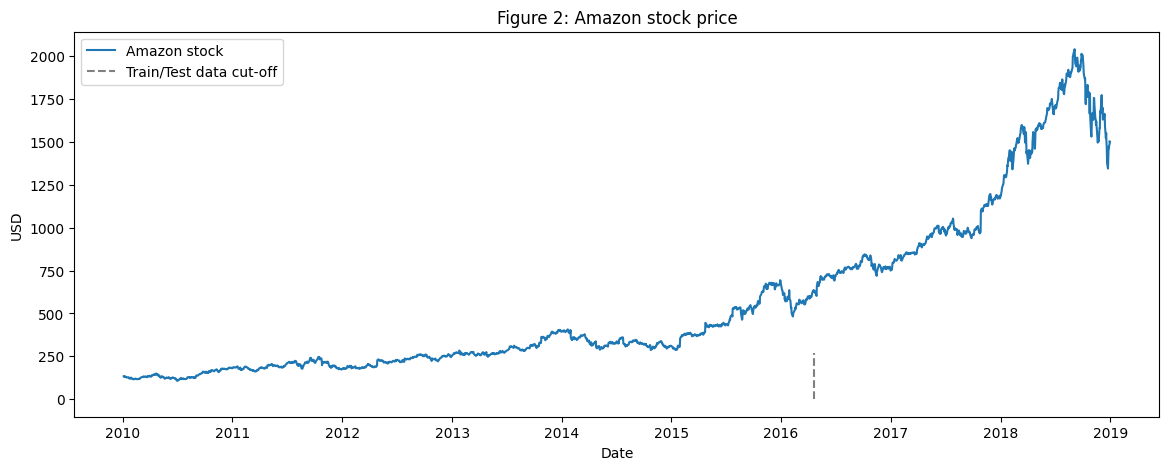

In [ ]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(dataset_ex_df['Date'], dataset_ex_df['Close'], label='Amazon stock')
plt.vlines(datetime.date(2016,4,20), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 2: Amazon stock price')
plt.legend()
plt.show()

In [ ]:
def get_technical_indicators(dataset): #function to generate feature technical indicators


    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Close'].rolling(window = 7).mean()
    dataset['ma21'] = dataset['Close'].rolling(window = 21).mean()

    #Create MACD
    dataset['26ema'] = dataset['Close'].ewm(span=26).mean()
    dataset['12ema'] = dataset['Close'].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    #Create Bollinger Bands
    dataset['20sd'] = dataset['Close'].rolling(window = 20).std()
    dataset['upper_band'] = (dataset['Close'].rolling(window = 20).mean()) + (dataset['20sd']*2)
    dataset['lower_band'] = (dataset['Close'].rolling(window = 20).mean()) - (dataset['20sd']*2)


    #Create Exponential moving average
    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()

    #Create Momentum
    dataset['momentum'] = (dataset['Close']/100)-1



    return dataset

List of technical indicators and explanation:

1. Bollinger bands: Bollinger Bands is used to define the prevailing high and low prices in a market to characterize the trading band of a financial instrument or commodity. Bollinger Bands are a volatility indicator. Bands are consists of Moving Average (MA) line, a upper band and lower band. The upper and lower bands are simply MA adding and subtracting standard deviation.

2. EMA: Exponential moving average is a better version of a simple moving average that doesnt have SMAs lag. Moving averages just average out the data for a given time so we know how the company's closing price are trending for a given amount of days. example for 4 days is price was 22,23 ,45,1 (the company crashed on 4th day) the average would be 23. Now 23 is a below average value so it gives us an idea that 45 was indeed just a fluke and that infact the company was always making losses EMA is calculated as: EMA(t)EMA(t0)=(1−α)EMA(t−1)+α p(t)=p(t0) where α=1L+1 and length of window is α=2M+1 I used the ewm(exponential weighted mean ) function to calculate ema.

3. Momentum: Momentum is perhaps the simplest and easiest oscillator (financial analysis tool) to understand and use. It is the measurement of the speed or velocity of price changes, or the rate of change in price movement for a particular asset.

The formula for momentum is:

Momentum=V−Vx where:

V=Latest price

Vx=Closing price

x=Number of days ago

Other features calculated are moving averages of 7 and 21 days and standard deviation.

Referred Links are:

https://www.learndatasci.com/tutorials/python-finance-part-3-moving-average-trading-strategy/

https://towardsdatascience.com/trading-technical-analysis-with-pandas-43e737a17861

In [ ]:
dataset_TI_df = get_technical_indicators(dataset_ex_df)

In [ ]:
dataset_TI_df.head()

,Date,Open,High,Low,Adj Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,Fourier,ARIMA,Close,labels
0,2010-01-04,136.250000,136.610001,133.139999,133.899994,7599900,NaN,NaN,133.899994,133.899994,0.000000,NaN,NaN,NaN,133.899994,0.3390,NaN,NaN,133.899994,NaN
1,2010-01-05,133.429993,135.479996,131.809998,134.690002,8851900,NaN,NaN,134.310190,134.327915,0.017725,NaN,NaN,NaN,134.492500,0.3469,NaN,NaN,134.690002,NaN
2,2010-01-06,134.600006,134.729996,131.649994,132.250000,7178800,NaN,NaN,133.569984,133.516904,-0.053080,NaN,NaN,NaN,132.940000,0.3225,NaN,NaN,132.250000,NaN
3,2010-01-07,132.009995,132.320007,128.800003,130.000000,11030200,NaN,NaN,132.571973,132.406755,-0.165217,NaN,NaN,NaN,130.955500,0.3000,NaN,NaN,130.000000,NaN
4,2010-01-08,130.559998,133.679993,129.029999,133.520004,9830500,NaN,NaN,132.791825,132.709221,-0.082604,NaN,NaN,NaN,132.672234,0.3352,NaN,NaN,133.520004,NaN


In [ ]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days

    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)

    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Close'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Amazon - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()


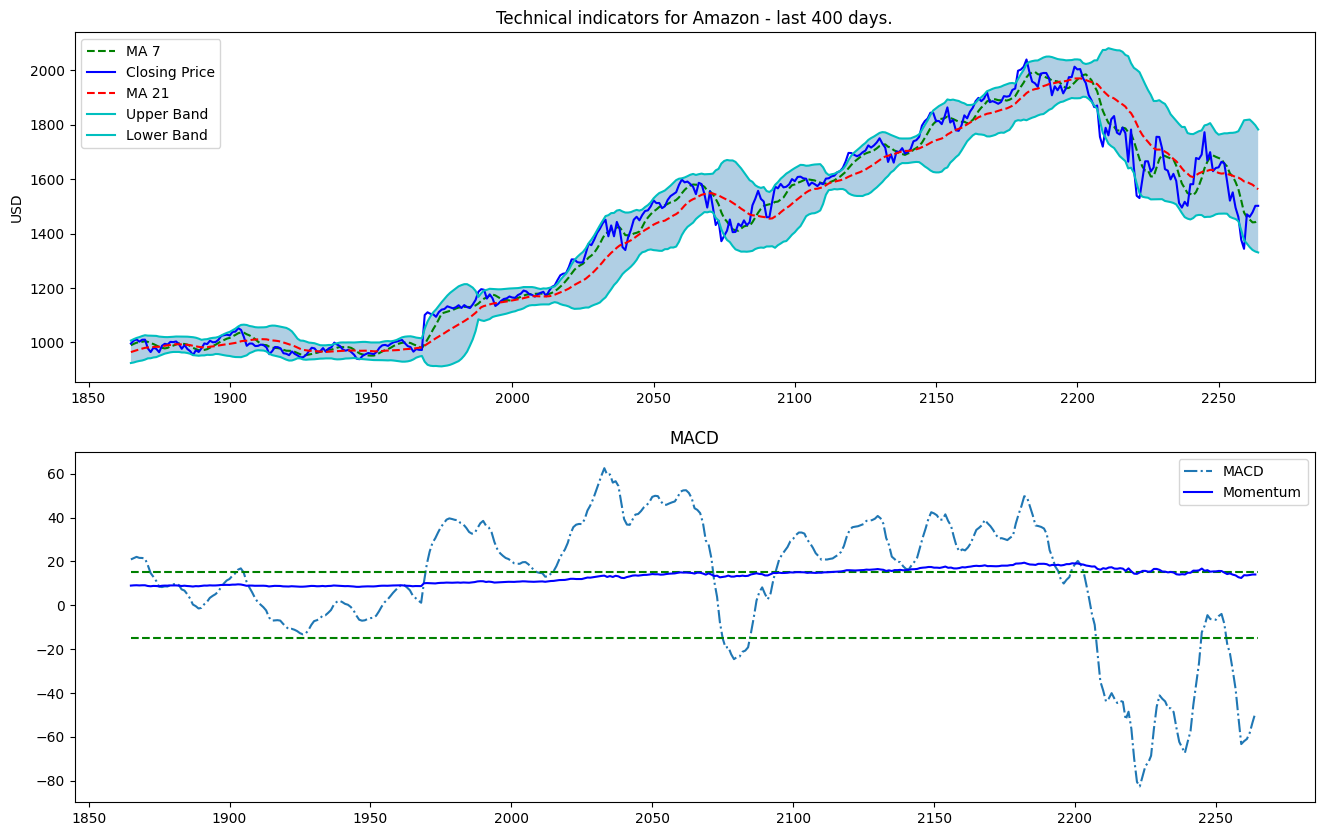

In [ ]:
plot_technical_indicators(dataset_TI_df, 400)

PLOT UNDERSTANDING:

THE FIRST PLOT IS SELF EXPLANATORY

THE SECOND PLOT IS SHOWING THE THRESHOLD BETWEEN MACD AND MOMENTUM. AS YOU CAN SEE MOMENTUM IS GIVING AN AVERAGE VALUE OF THE MACD IN BETEEEN THE PEAK VALUES AND THE HIGHEST OR LOWEST VALUES. MACD DEPENDS ON THE MOVING AVERAGE FEATURES AS CALCULATED ABOVE

# ANALYSIS OF TIME SERIES USING FOURIER TRANSFORM

In [ ]:
data_FT = dataset_ex_df[['Date', 'Close']]
close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

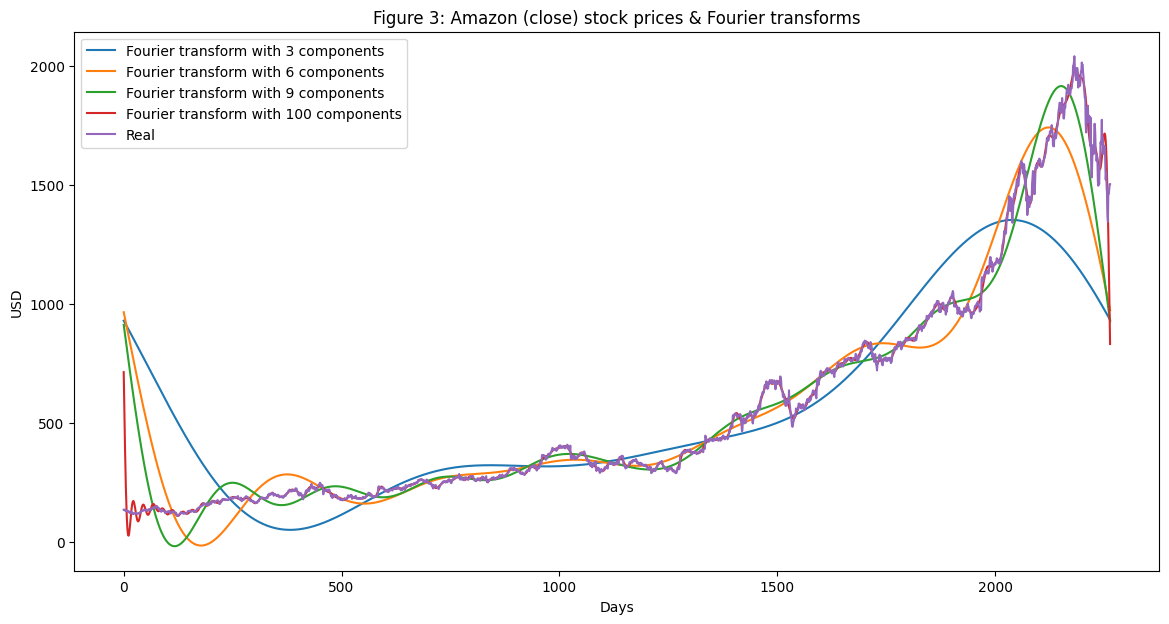

In [ ]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data_FT['Close'],  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 3: Amazon (close) stock prices & Fourier transforms')
plt.legend()
plt.show()

Fourier Transform uses many spectral components to try and train data. From time domain its converted to frequency domain and then calculated. After that it's reconverted into time domain where it's plotted. Fourier Transform as indicator helps to extract predominate cycle from a series of data

Reference: https://www.metastock.com/customer/resources/taaz/?p=58

In the above example we can see the spectral component of 100 is closest to the real price so we will move ahead ith 100

In [ ]:
def get_fourier(dataset):
    data_FT = dataset[['Date', 'Close']]
    close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
    close_fft = np.fft.ifft(close_fft)
    close_fft
    fft_df = pd.DataFrame({'fft':close_fft})
    fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
    fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
    fft_list = np.asarray(fft_df['fft'].tolist())
    fft_list_m10= np.copy(fft_list); fft_list_m10[100:-100]=0
    dataset['Fourier'] = pd.DataFrame(fft_list_m10).apply(lambda x: np.abs(x))
    #dataset['absolute'] = dataset['Fourier'].apply(lambda x: np.abs(x))
    return dataset


In [ ]:
dataset_TI_df = get_fourier(dataset_ex_df)

In [ ]:
dataset_TI_df.head()

,Date,Open,High,Low,Adj Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,Fourier,ARIMA,Close,labels
0,2010-01-04,136.250000,136.610001,133.139999,133.899994,7599900,NaN,NaN,133.899994,133.899994,0.000000,NaN,NaN,NaN,133.899994,0.3390,133.899994,NaN,133.899994,NaN
1,2010-01-05,133.429993,135.479996,131.809998,134.690002,8851900,NaN,NaN,134.310190,134.327915,0.017725,NaN,NaN,NaN,134.492500,0.3469,134.690002,NaN,134.690002,NaN
2,2010-01-06,134.600006,134.729996,131.649994,132.250000,7178800,NaN,NaN,133.569984,133.516904,-0.053080,NaN,NaN,NaN,132.940000,0.3225,132.250000,NaN,132.250000,NaN
3,2010-01-07,132.009995,132.320007,128.800003,130.000000,11030200,NaN,NaN,132.571973,132.406755,-0.165217,NaN,NaN,NaN,130.955500,0.3000,130.000000,NaN,130.000000,NaN
4,2010-01-08,130.559998,133.679993,129.029999,133.520004,9830500,NaN,NaN,132.791825,132.709221,-0.082604,NaN,NaN,NaN,132.672234,0.3352,133.520004,NaN,133.520004,NaN


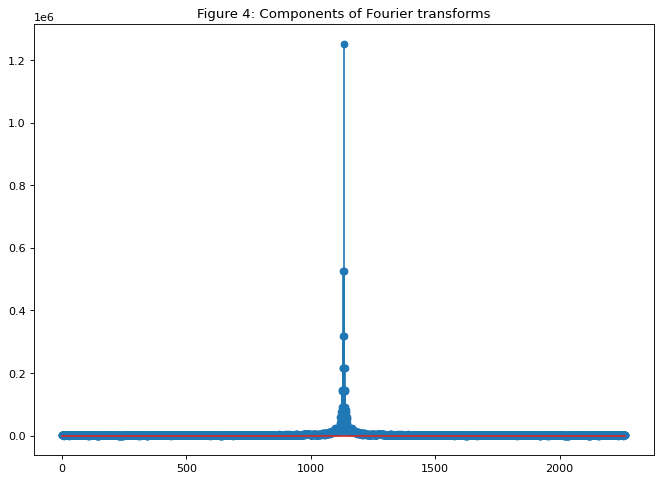

In [ ]:
from collections import deque
items = deque(np.asarray(fft_df['absolute'].tolist()))
items.rotate(int(np.floor(len(fft_df)/2)))
plt.figure(figsize=(10, 7), dpi=80)
plt.stem(items)
plt.title('Figure 4: Components of Fourier transforms')
plt.show()

Component analysis of Fourier Transform: Once the spectral part of Fourier transform is removed the magnitude part is quite close to the test series values.Hence it is working.

# ARIMA


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from pandas import DataFrame
from datetime import datetime

series = data_FT['Close']
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2265
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -9247.127
Date:                Tue, 14 Jan 2025   AIC                          18506.254
Time:                        02:22:19   BIC                          18540.604
Sample:                             0   HQIC                         18518.788
                               - 2265                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0250      0.008     -3.268      0.001      -0.040      -0.010
ar.L2          0.0018      0.007      0.256      0.798      -0.012       0.016
ar.L3         -0.0274      0.008     -3.505      0.0

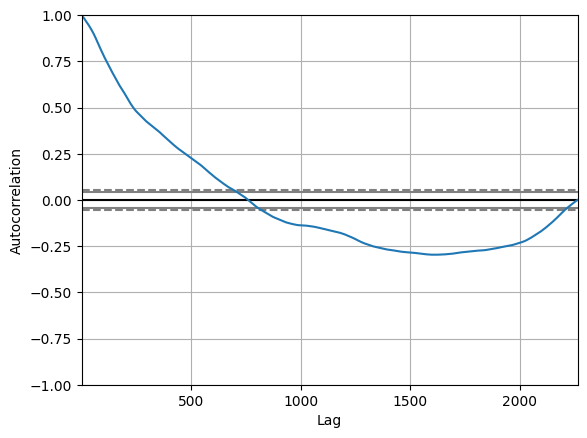

<Figure size 800x560 with 0 Axes>

In [ ]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show()

Refernce to ARIMA code:

https://towardsdatascience.com/forecasting-exchange-rates-using-arima-in-python-f032f313fc56

https://github.com/gmonaci/ARIMA

ARIMA Explantion :

https://towardsdatascience.com/forecasting-exchange-rates-using-arima-in-python-f032f313fc56

In [ ]:
from pandas import read_csv
from datetime import datetime
from pandas import DataFrame
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

dataset_TI_df['ARIMA'] = pd.DataFrame(predictions)

In [ ]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)     # MSE ideally should be in the range of 30 to 100 to be considered

Test MSE: 558.310


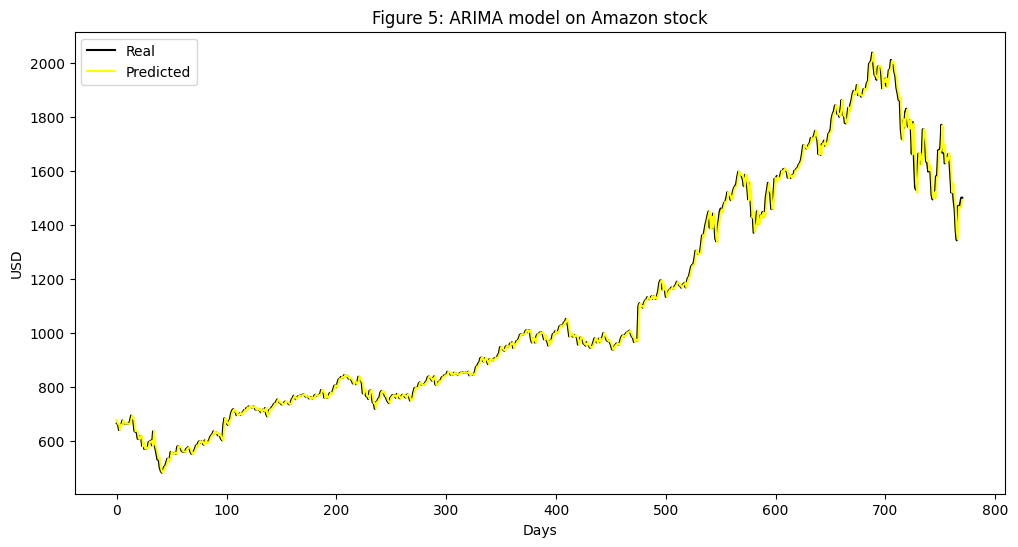

In [ ]:
# Plot the predicted (from ARIMA) and real prices

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, color='black', label='Real')
plt.plot(predictions, color='yellow', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 5: ARIMA model on Amazon stock')
plt.legend()
plt.show()

As we can see from Figure, ARIMA gives a very good approximation of the real stock price. We will use the predicted price through ARIMA as an input feature into the LSTM because we want to capture as many features and patterns about Amazon as possible.

In [ ]:
dataset_ex_df.head(8)

,Date,Open,High,Low,Adj Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,Fourier,ARIMA,Close,labels
0,2010-01-04,136.250000,136.610001,133.139999,133.899994,7599900,NaN,NaN,133.899994,133.899994,0.000000,NaN,NaN,NaN,133.899994,0.3390,133.899994,677.897491,133.899994,NaN
1,2010-01-05,133.429993,135.479996,131.809998,134.690002,8851900,NaN,NaN,134.310190,134.327915,0.017725,NaN,NaN,NaN,134.492500,0.3469,134.690002,663.596692,134.690002,NaN
2,2010-01-06,134.600006,134.729996,131.649994,132.250000,7178800,NaN,NaN,133.569984,133.516904,-0.053080,NaN,NaN,NaN,132.940000,0.3225,132.250000,662.984084,132.250000,NaN
3,2010-01-07,132.009995,132.320007,128.800003,130.000000,11030200,NaN,NaN,132.571973,132.406755,-0.165217,NaN,NaN,NaN,130.955500,0.3000,130.000000,639.695373,130.000000,NaN
4,2010-01-08,130.559998,133.679993,129.029999,133.520004,9830500,NaN,NaN,132.791825,132.709221,-0.082604,NaN,NaN,NaN,132.672234,0.3352,133.520004,660.141132,133.520004,NaN
5,2010-01-11,132.619995,132.800003,129.210007,130.309998,8779400,NaN,NaN,132.294735,132.126083,-0.168651,NaN,NaN,NaN,131.095247,0.3031,130.309998,658.517020,130.309998,NaN
6,2010-01-12,128.990005,129.820007,126.550003,127.349998,9096300,131.717142,NaN,131.415339,131.060317,-0.355022,NaN,NaN,NaN,128.597272,0.2735,127.349998,676.090400,127.349998,NaN
7,2010-01-13,127.900002,129.710007,125.750000,129.110001,10723200,131.032858,NaN,131.043892,130.653316,-0.390576,NaN,NaN,NaN,128.939143,0.2911,129.110001,668.734754,129.110001,NaN


In [ ]:
dataset_ex_df.shape

(2265, 20)

FINDING IMPORTANT FEATURES USING XGBOOST :

In [ ]:
def get_feature_importance_data(data_income):
    data = data_income.copy()
    y = data['Close']
    X = data.iloc[:,1:19]

    train_samples = int(X.shape[0] * 0.65)

    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]

    return (X_train, y_train), (X_test, y_test)

In [ ]:
# Get training and test data
(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(dataset_TI_df)

In [ ]:
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=200,base_score=0.7,colsample_bytree=1,learning_rate=0.05)

In [ ]:
xgbModel = regressor.fit(X_train_FI,y_train_FI, \
                         eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], \
                         verbose=False)

In [ ]:
eval_result = regressor.evals_result()

In [ ]:
training_rounds = range(len(eval_result['validation_0']['rmse']))

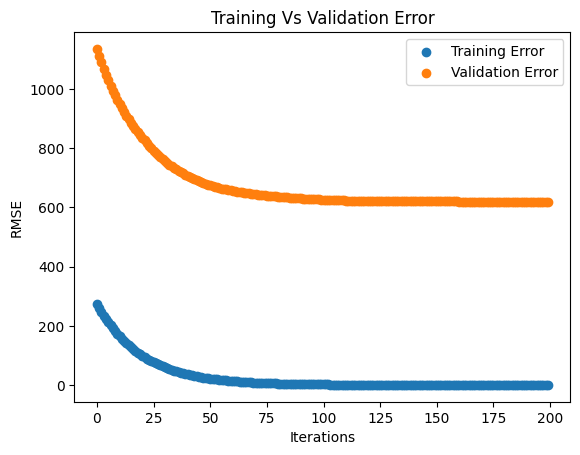

In [ ]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

THE DIFFERENCE BETWEEN VALIDATION AND TRAINING ERROR SHOWS A UNDERFIT MODEL BECAUSE OF THE WAY TRAINING AND TESTING DATA IS SPLIT JUST WHEN AMAZON BOOMS.

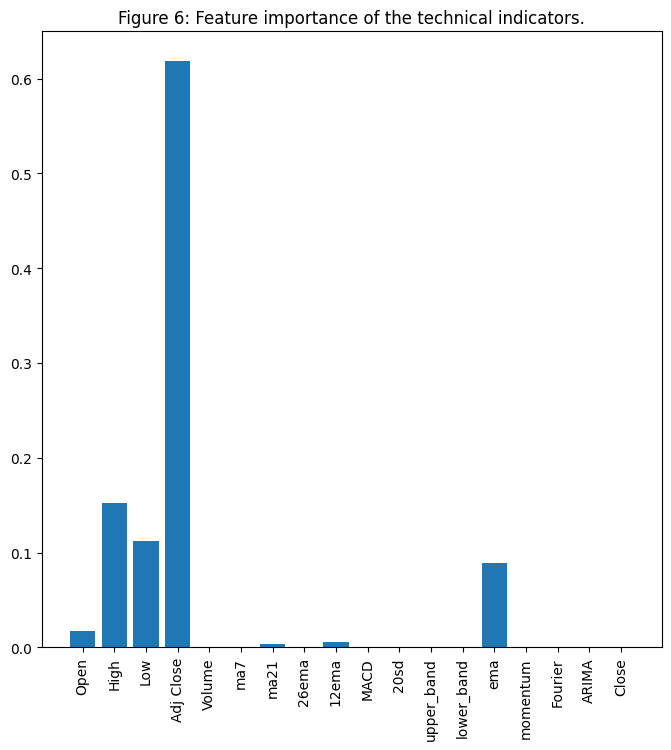

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
plt.title('Figure 6: Feature importance of the technical indicators.')
plt.show()

# LSTM

In [ ]:
#1. take dataframe and drop na
dataset_lstm_df = dataset_TI_df.drop(columns='Date')
dataset_lstm_df.head(7)

,Open,High,Low,Adj Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,Fourier,ARIMA,Close,labels
0,136.250000,136.610001,133.139999,133.899994,7599900,NaN,NaN,133.899994,133.899994,0.000000,NaN,NaN,NaN,133.899994,0.3390,133.899994,677.897491,133.899994,NaN
1,133.429993,135.479996,131.809998,134.690002,8851900,NaN,NaN,134.310190,134.327915,0.017725,NaN,NaN,NaN,134.492500,0.3469,134.690002,663.596692,134.690002,NaN
2,134.600006,134.729996,131.649994,132.250000,7178800,NaN,NaN,133.569984,133.516904,-0.053080,NaN,NaN,NaN,132.940000,0.3225,132.250000,662.984084,132.250000,NaN
3,132.009995,132.320007,128.800003,130.000000,11030200,NaN,NaN,132.571973,132.406755,-0.165217,NaN,NaN,NaN,130.955500,0.3000,130.000000,639.695373,130.000000,NaN
4,130.559998,133.679993,129.029999,133.520004,9830500,NaN,NaN,132.791825,132.709221,-0.082604,NaN,NaN,NaN,132.672234,0.3352,133.520004,660.141132,133.520004,NaN
5,132.619995,132.800003,129.210007,130.309998,8779400,NaN,NaN,132.294735,132.126083,-0.168651,NaN,NaN,NaN,131.095247,0.3031,130.309998,658.517020,130.309998,NaN
6,128.990005,129.820007,126.550003,127.349998,9096300,131.717142,NaN,131.415339,131.060317,-0.355022,NaN,NaN,NaN,128.597272,0.2735,127.349998,676.090400,127.349998,NaN


In [ ]:
dataset_lstm_df.shape

(2265, 19)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Flatten

In [ ]:
train, validate, test = np.split(dataset_lstm_df.sample(frac=1), [int(.6*len(dataset_lstm_df)), int(.8*len(dataset_lstm_df))])

Split dataset into train,test and validate sets

In [ ]:
open_training = train.iloc[:, 1:2].values

The data is not normalized and the range for each column varies, especially Volume. Normalizing data helps the algorithm in converging i.e. to find local/ global minimum efficiently. We will use MinMaxScaler from Scikit Learn. Use a range to keep values similar for that much range

Keep a window for the length 2000 for your data between 50 and 500...since our length is slightly more than 2000 ill make it 60 to 450

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
open_training = scaler.fit_transform(open_training)
#convert to right shape
features_set_1 = []
labels_1 = []
for i in range(60,450):
    features_set_1.append(open_training[i-60:i, 0])
    labels_1.append(open_training[i, 0])

Convert feature set and label set into arrays and shape feature set into a 3D input that LSTM network demands

In [ ]:
features_set_1, labels_1 = np.array(features_set_1), np.array(labels_1)
features_set_1 = np.reshape(features_set_1, (features_set_1.shape[0], features_set_1.shape[1], 1))

In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(features_set_1.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mean_absolute_error'])
model.fit(features_set_1, labels_1, epochs = 100, batch_size = 32,validation_data = (features_set_1, labels_1))

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 0.0741 - mean_absolute_error: 0.1987 - val_loss: 0.0642 - val_mean_absolute_error: 0.1753
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0749 - mean_absolute_error: 0.2000 - val_loss: 0.0594 - val_mean_absolute_error: 0.1839
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0613 - mean_absolute_error: 0.1935 - val_loss: 0.0585 - val_mean_absolute_error: 0.1896
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0571 - mean_absolute_error: 0.1859 - val_loss: 0.0584 - val_mean_absolute_error: 0.1914
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0624 - mean_absolute_error: 0.1966 - val_loss: 0.0583 - val_mean_absolute_error: 0.1881
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0597 - mean_absolute_error: 0.1919 - val_loss: 0.0597 - val_mean_absolute_error: 0.1804
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0599 - mean_absolute_error: 0.1918 - v

Data is trained for 100 epochs optimizer is adam and loss is mse. This seems to be an average model because mean absolute error is 0.19 and val mean absolute error is 0.17 so it indicates overfitting. Since this is a regression problem accuracy is not a good metric. MAE was chosen since the difference between training and testing should be less so we don't need to take the square root of the value.

We will focus on hyperparameters if this model is good at prediction



In [ ]:
#TESTING THE MODEL
open_testing_processed = test.iloc[:, 1:2].values

Test the model on test data

In [ ]:
#convert test data to right format
open_total = pd.concat((train['Open'], test['Open']), axis=0)

Start predictions: Reshape, scale and then oredict the model

In [ ]:
test_inputs = open_total[len(open_total) - len(test) - 60:].values

In [ ]:
#scaling data
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)

In [ ]:
test_features = []
for i in range(60, 151):
    test_features.append(test_inputs[i-60:i, 0])

In [ ]:
test_features = np.array(test_features)
test_features.shape
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))

In [ ]:
#make predictions
predictions = model.predict(test_features)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step


In [ ]:
predictions = scaler.inverse_transform(predictions)

Plot the prediction model for the number of test days and train days

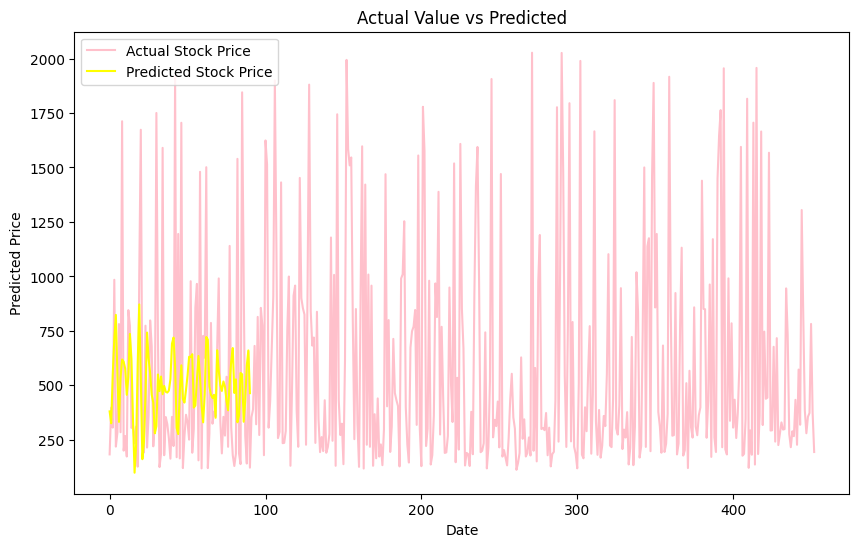

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(open_testing_processed, color='pink', label='Actual Stock Price')
plt.plot(predictions , color='yellow', label='Predicted Stock Price')
plt.title('Actual Value vs Predicted')
plt.xlabel('Date')
plt.ylabel('Predicted Price')
plt.legend()
plt.show()

This wasn't a great result with one feature so let's try using more features and then train them on LSTM model

USING 5FEATURES :

USING THE BEST 5 FEATURES FROM THE RESULT OF THE XGBOOST. ITS QUITE OBVIOUS THAT A SINGLE FEATURE WILL NOT WORK SO WE USE THE 6 FEATURES THAT COULD GENERATE THE BEST OUTCOME FROM XGBOOST

In [ ]:
dataset = dataset_ex_df[['Open', 'Close','High','Adj Close','Low']]

In [ ]:
dataset.head()

,Open,Close,High,Adj Close,Low
0,136.250000,133.899994,136.610001,133.899994,133.139999
1,133.429993,134.690002,135.479996,134.690002,131.809998
2,134.600006,132.250000,134.729996,132.250000,131.649994
3,132.009995,130.000000,132.320007,130.000000,128.800003
4,130.559998,133.520004,133.679993,133.520004,129.029999


In [ ]:
# FUNCTION TO CREATE 1D DATA INTO TIME SERIES DATASET
def new_dataset(dataset, step_size):
	data_X, data_Y = [], []
	for i in range(len(dataset)-step_size-1):
		a = dataset[i:(i+step_size), 0]
		data_X.append(a)
		data_Y.append(dataset[i + step_size, 0])
	return np.array(data_X), np.array(data_Y)

In [ ]:
# IMPORTING IMPORTANT LIBRARIES
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM

In [ ]:
# FOR REPRODUCIBILITY
np.random.seed(7)

In [ ]:
# IMPORTING DATASET
dataset = dataset.reindex(index = dataset.index[::-1])

In [ ]:
# CREATING OWN INDEX FOR FLEXIBILITY
obs = np.arange(1, len(dataset) + 1, 1)

In [ ]:
# TAKING DIFFERENT INDICATORS FOR PREDICTION
OHLC_avg = dataset.mean(axis = 1)
HLC_avg = dataset[['High', 'Low', 'Close']].mean(axis = 1)
close_val = dataset[['Close']]

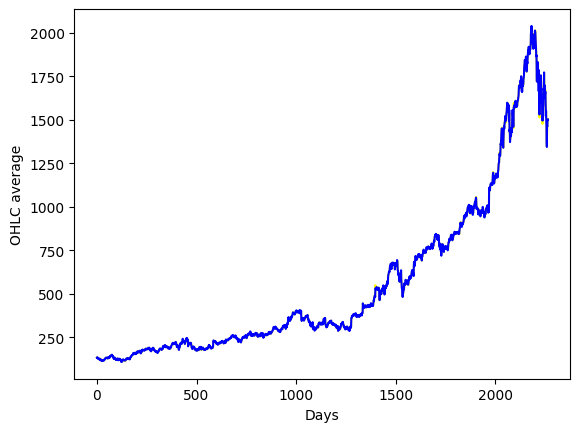

In [ ]:
# PLOTTING All INDICATORS IN PLOT
plt.plot(OHLC_avg, 'yellow', label = 'OHLC avg')
plt.plot(close_val, 'blue', label = 'Closing price')
plt.xlabel('Days')
plt.ylabel('OHLC average')
plt.show()

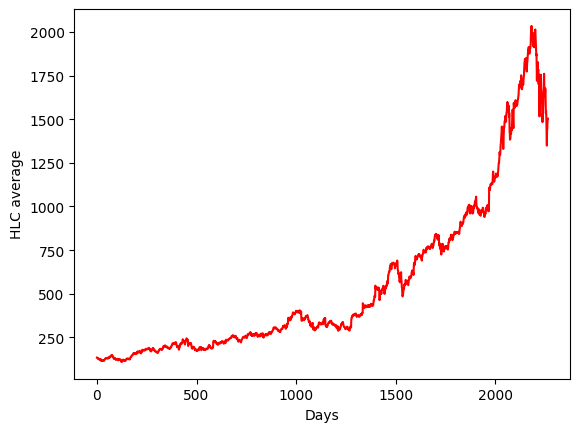

In [ ]:
plt.plot(HLC_avg, 'red', label = 'HLC avg')
plt.xlabel('Days')
plt.ylabel('HLC average')
plt.show()

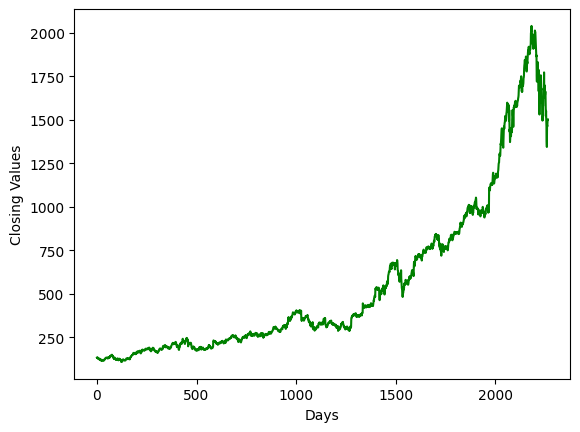

In [ ]:
plt.plot(close_val, 'green', label = 'Closing price')
plt.xlabel('Days')
plt.ylabel('Closing Values')
plt.show()

In [ ]:
# PREPARATION OF TIME SERIES DATASE
OHLC_avg = np.reshape(OHLC_avg.values, (len(OHLC_avg),1))
scaler = MinMaxScaler(feature_range=(0, 1))
OHLC_avg = scaler.fit_transform(OHLC_avg)

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [ ]:
# TRAIN-TEST SPLIT
train_OHLC = int(len(OHLC_avg) * 0.75)
test_OHLC = len(OHLC_avg) - train_OHLC
train_OHLC, test_OHLC = OHLC_avg[0:train_OHLC,:], OHLC_avg[train_OHLC:len(OHLC_avg),:]

In [ ]:
# TIME-SERIES DATASET (FOR TIME T, VALUES FOR TIME T+1)
trainX, trainY = new_dataset(train_OHLC, 1)
testX, testY = new_dataset(test_OHLC, 1)

In [ ]:
# RESHAPING TRAIN AND TEST DATA
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
step_size = 1


In [ ]:
# LSTM MODEL
model = Sequential()
model.add(LSTM(32, input_shape=(1, step_size), return_sequences = True))
model.add(LSTM(16))
model.add(Dense(1))
model.add(Activation('linear'))

In [ ]:
# MODEL COMPILING AND TRAINING
model.compile(loss='mean_squared_error', optimizer='adagrad',metrics = ['mae']) # Try mae, adam, adagrad and compare!!!
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)

Epoch 1/50
1696/1696 - 7s - 4ms/step - loss: 0.0159 - mae: 0.1034
Epoch 2/50
1696/1696 - 11s - 6ms/step - loss: 0.0132 - mae: 0.0941
Epoch 3/50
1696/1696 - 11s - 6ms/step - loss: 0.0111 - mae: 0.0864
Epoch 4/50
1696/1696 - 9s - 5ms/step - loss: 0.0094 - mae: 0.0794
Epoch 5/50
1696/1696 - 6s - 4ms/step - loss: 0.0079 - mae: 0.0731
Epoch 6/50
1696/1696 - 9s - 5ms/step - loss: 0.0066 - mae: 0.0669
Epoch 7/50
1696/1696 - 6s - 4ms/step - loss: 0.0056 - mae: 0.0611
Epoch 8/50
1696/1696 - 9s - 6ms/step - loss: 0.0046 - mae: 0.0558
Epoch 9/50
1696/1696 - 6s - 3ms/step - loss: 0.0038 - mae: 0.0508
Epoch 10/50
1696/1696 - 11s - 6ms/step - loss: 0.0032 - mae: 0.0461
Epoch 11/50
1696/1696 - 9s - 5ms/step - loss: 0.0026 - mae: 0.0417
Epoch 12/50
1696/1696 - 6s - 4ms/step - loss: 0.0021 - mae: 0.0377
Epoch 13/50
1696/1696 - 9s - 6ms/step - loss: 0.0018 - mae: 0.0341
Epoch 14/50
1696/1696 - 10s - 6ms/step - loss: 0.0014 - mae: 0.0305
Epoch 15/50
1696/1696 - 6s - 4ms/step - loss: 0.0012 - mae: 0.0274


In [ ]:
mae = model.evaluate(testX, testY, batch_size=16)
print('Mean Absolute Error for Y:', mae)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3539e-05 - mae: 0.0033
Mean Absolute Error for Y: [1.7314734577666968e-05, 0.0038060660008341074]


The mean absolute error is lower than the past model with one feature. The errror is almost 0.0038. So the training model should be pretty close to testing model.



In [ ]:
# PREDICTION
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [ ]:
# DE-NORMALIZING FOR PLOTTING
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [ ]:
# TRAINING rmse
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train : %.2f' % (trainScore))

Train : 14.56


In [ ]:
# TEST RMSE
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testScore))

Test RMSE: 8.01


In [ ]:
# CREATING SIMILAR DATASET TO PLOT TRAINING PREDICTIONS
trainPredictPlot = np.empty_like(OHLC_avg)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step_size:len(trainPredict)+step_size, :] = trainPredict

In [ ]:
# CREATING SIMILAR DATASSET TO PLOT TEST PREDICTIONS
testPredictPlot = np.empty_like(OHLC_avg)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(step_size*2)+1:len(OHLC_avg)-1, :] = testPredict

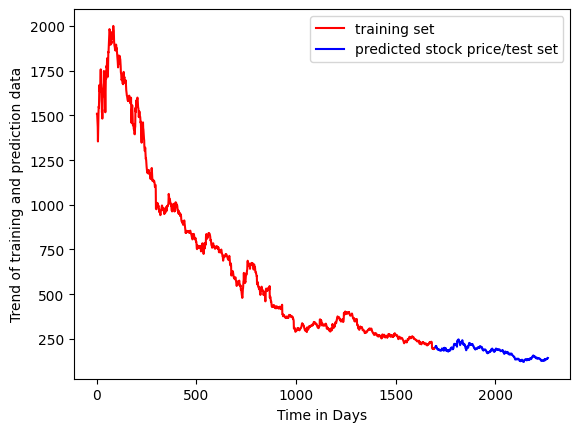

In [ ]:
# PLOT OF MAIN OHLC VALUES, TRAIN PREDICTIONS AND TEST PREDICTIONS
plt.plot(trainPredictPlot, 'r', label = 'training set')
plt.plot(testPredictPlot, 'b', label = 'predicted stock price/test set')
plt.legend(loc = 'upper right')
plt.xlabel('Time in Days')
plt.ylabel('Trend of training and prediction data')
plt.show()

In [ ]:
# PREDICT FUTURE VALUES
last_val = testPredict[-1]
last_val_scaled = last_val/last_val
next_val = model.predict(np.reshape(last_val_scaled, (1,1,1)))
print("Last Day Value:", last_val.item())
print("Next Day Value:", last_val*next_val.item())
# print np.append(last_val, next_val)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Last Day Value: 142.400146484375
Next Day Value: [139.98111]
